# Insurance Customers Clustering App

> By Alex Ordonez & Vishaka Sharma

# Table of contents

* [1. Project Introduction]
* [2. Business Objective & Problem Statement]
* [3. Dataset Overview]
* [4. Data Cleaning & Preprocessing]
* [5. Exploratory Data Analysis (EDA)]
* [6. Clustering Approaches].
    * [6.1. K-Means Clustering]
    * [6.2. Gaussian Mixture Models (GMM)]
    * [6.3 Hierarchical Clustering]
    * [6.4 DBSCAN]
* [7. Cluster Profiling & Insights]
* [8. Recommendations for Business Strategy]
* [9. Conclusion]
* [10. Appendix (Code Snippets & Charts)]

## Project Objective

The objective of this project is to segment insurance customers using unsupervised machine learning techniques. By identifying customer clusters based on behavioral and demographic attributes, we aim to tailor marketing strategies, predict premium behaviors, and enhance customer retention.

## Import Libraries 

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from math import ceil
# Clustering Support
from sklearn.mixture import GaussianMixture


## Load Dataset

In [3]:
# Load Dataset
df = pd.read_csv(r"./synthetic_insurance_data.csv")

## Initial Data Exploration

In [5]:
# Overview of data
df.info()

# Summary statistics (including categorical)
df.describe(include='all')

# View first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 10000 non-null  int64 
 1   Is_Senior                           10000 non-null  int64 
 2   Marital_Status                      10000 non-null  object
 3   Married_Premium_Discount            10000 non-null  int64 
 4   Prior_Insurance                     10000 non-null  object
 5   Prior_Insurance_Premium_Adjustment  10000 non-null  int64 
 6   Claims_Frequency                    10000 non-null  int64 
 7   Claims_Severity                     10000 non-null  object
 8   Claims_Adjustment                   10000 non-null  int64 
 9   Policy_Type                         10000 non-null  object
 10  Policy_Adjustment                   10000 non-null  int64 
 11  Premium_Amount                      10000 non-null  int

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
0,47,0,Married,86,1-5 years,50,0,Low,0,Full Coverage,...,10,0,5,1,2,99,704,-50,Suburban,50
1,37,0,Married,86,1-5 years,50,0,Low,0,Full Coverage,...,22,0,5,1,2,99,726,-50,Urban,100
2,49,0,Married,86,1-5 years,50,1,Low,50,Full Coverage,...,28,0,4,4,1,99,772,-50,Urban,100
3,62,1,Married,86,>5 years,0,1,Low,50,Full Coverage,...,4,1,6,2,2,2,809,-50,Urban,100
4,36,0,Single,0,>5 years,0,2,Low,100,Full Coverage,...,14,1,8,4,2,10,662,50,Suburban,50


### Initial Visualizations - Spearman Correlation matrix

Highly Correlated Feature Pairs:
 Claims_Frequency    Claims_Adjustment     0.98
Claims_Adjustment   Claims_Frequency      0.98
Conversion_Status   Time_to_Conversion   -0.89
Time_to_Conversion  Conversion_Status    -0.89
dtype: float64


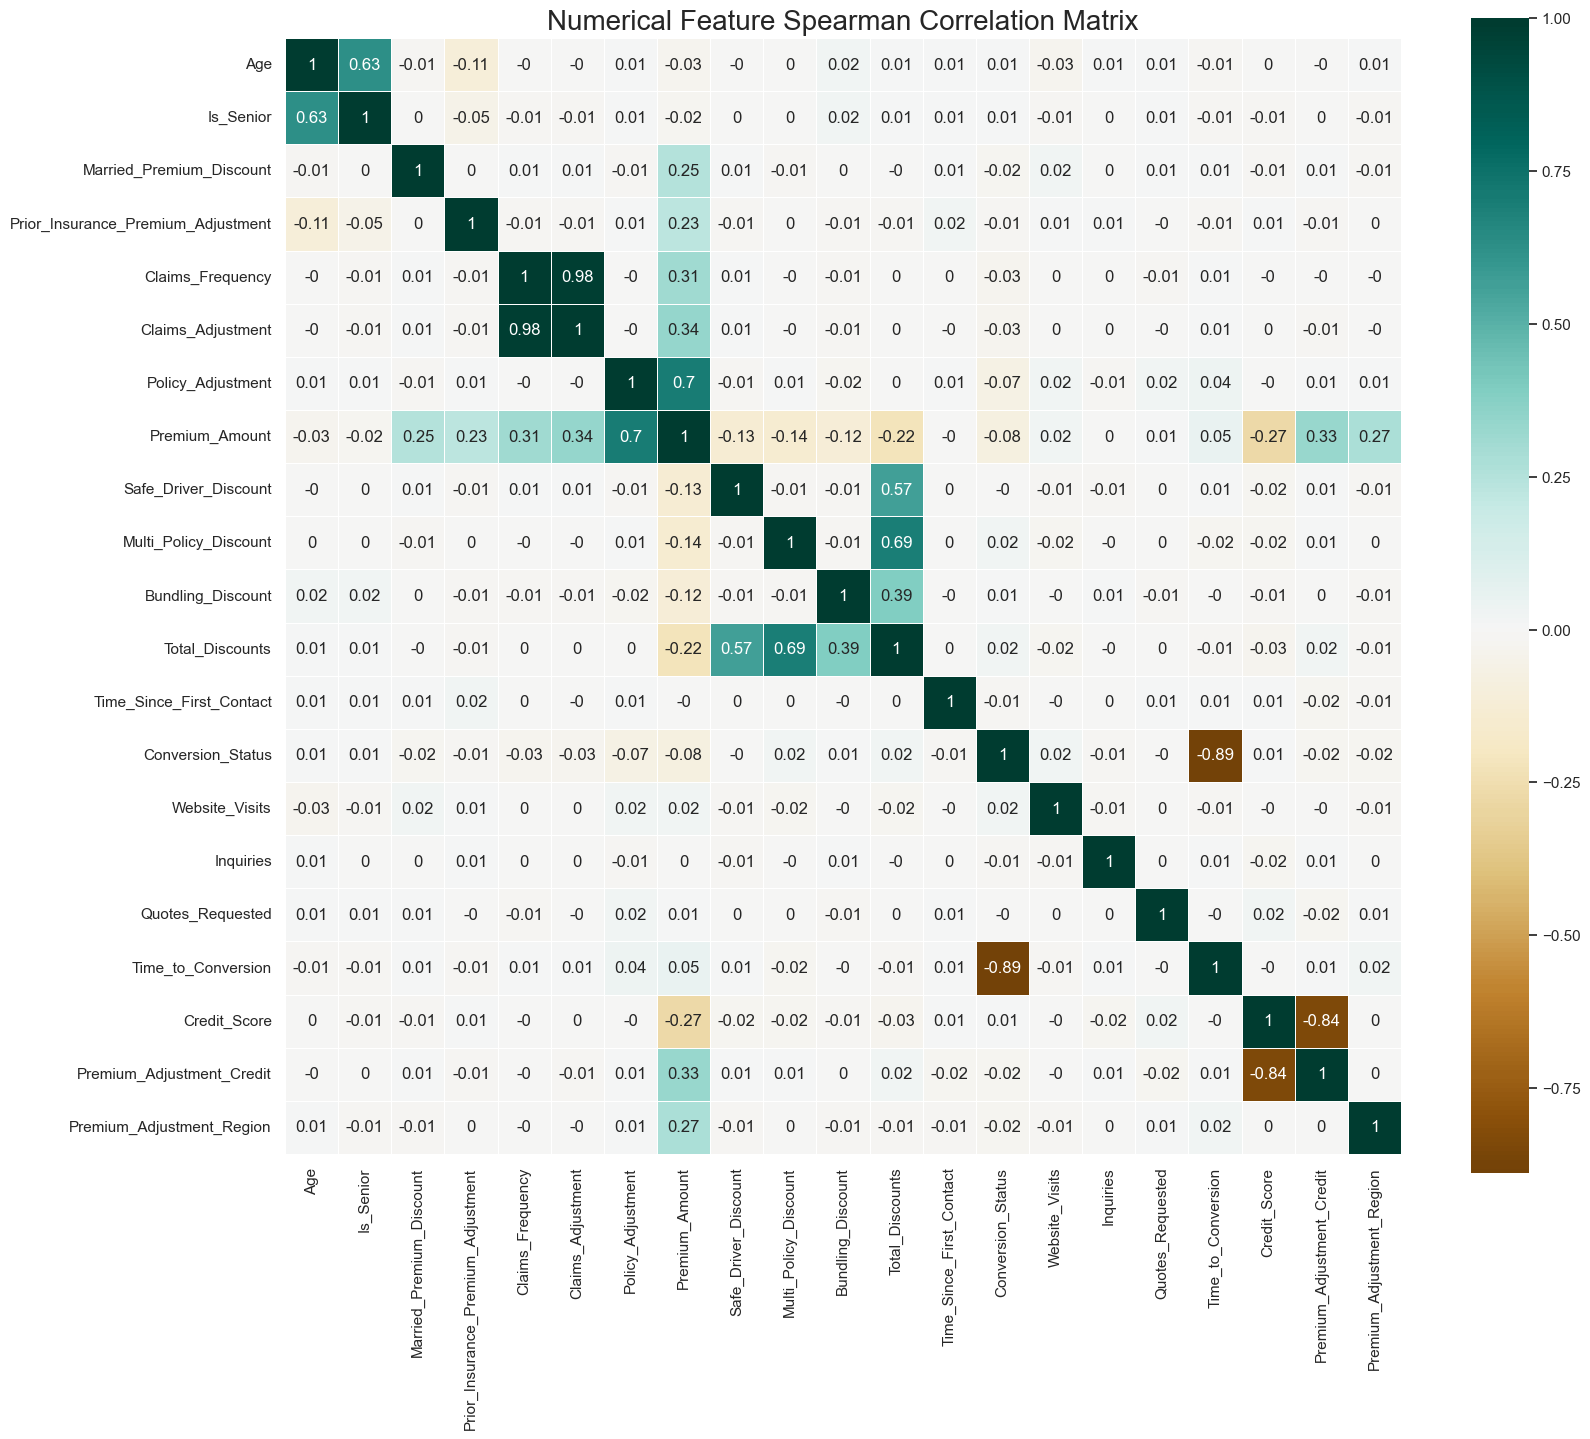

In [6]:
# Select and fill numeric columns
numeric_cols = df.select_dtypes(include=[np.number])
numeric_cols = numeric_cols.fillna(numeric_cols.median())

# Compute Spearman correlation matrix
corr_matrix = np.round(numeric_cols.corr(method='spearman'), decimals=2)

# Convert correlation matrix to pairs
corr_pairs = corr_matrix.unstack()

# Remove self-correlations (values exactly = 1)
corr_pairs = corr_pairs[corr_pairs < 1]

# Define threshold for high correlations (e.g., 0.85)
threshold = 0.85
high_corr = corr_pairs[np.abs(corr_pairs) > threshold]

# Display highly correlated feature pairs
print("Highly Correlated Feature Pairs:\n", high_corr)

plt.figure(figsize=(18, 15))
sns.heatmap(data=corr_matrix, annot=True, cmap="BrBG", center=0, linewidths=0.5, square=True)
plt.title("Numerical Feature Spearman Correlation Matrix", fontsize=20)
plt.show()

*Time_to_Conversion* is highly correlated with *Conversion_Status*. From this point forward, we will retain only one of them to avoid redundancy and multicollinearity in the dataset.

# Distribution Plots for Key Numeric Features

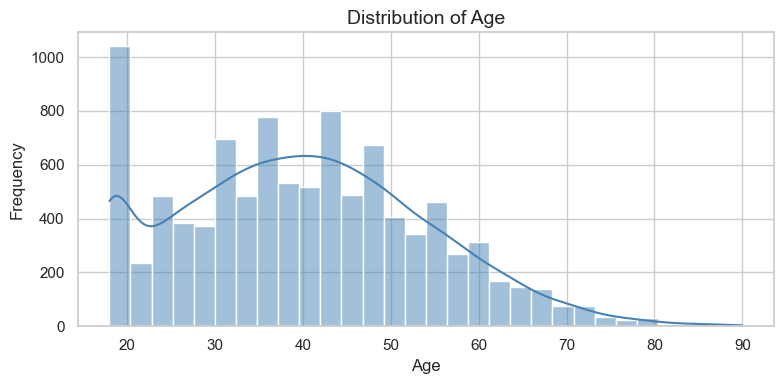

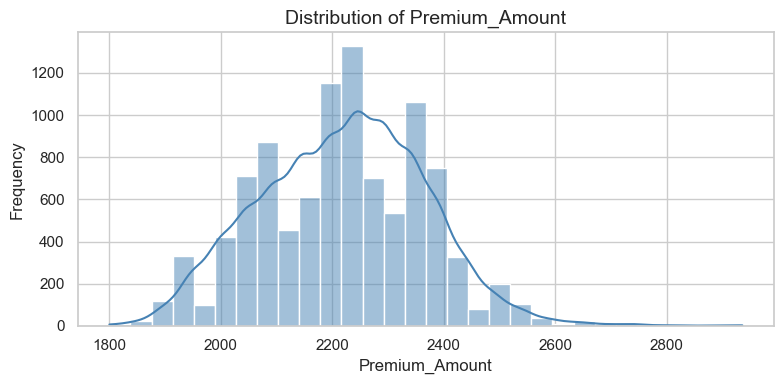

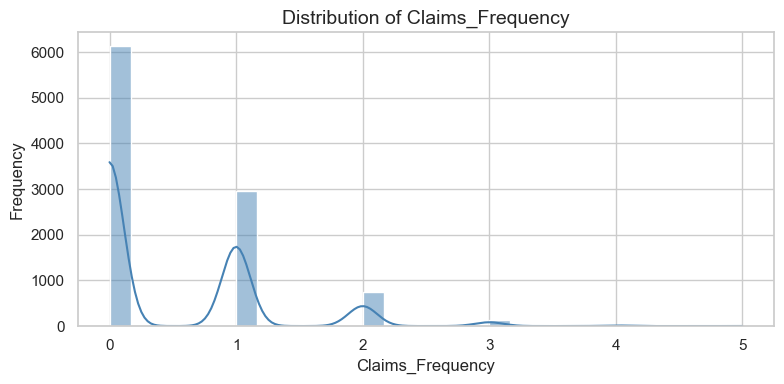

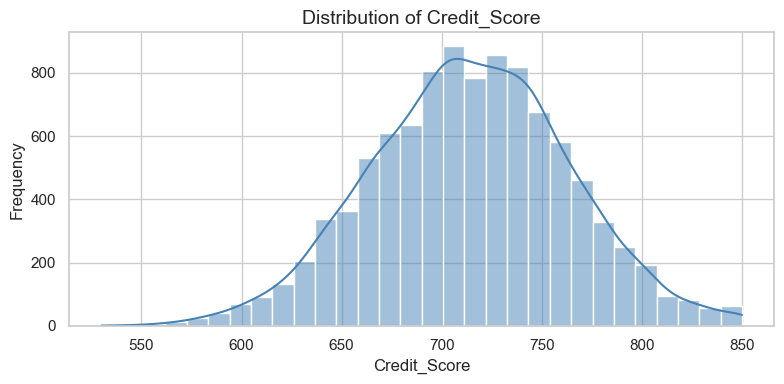

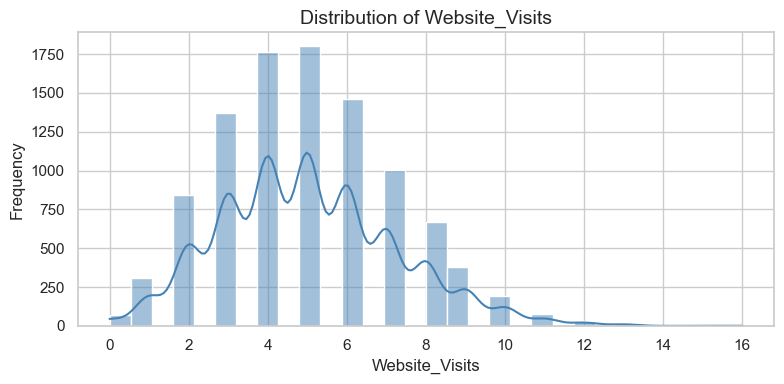

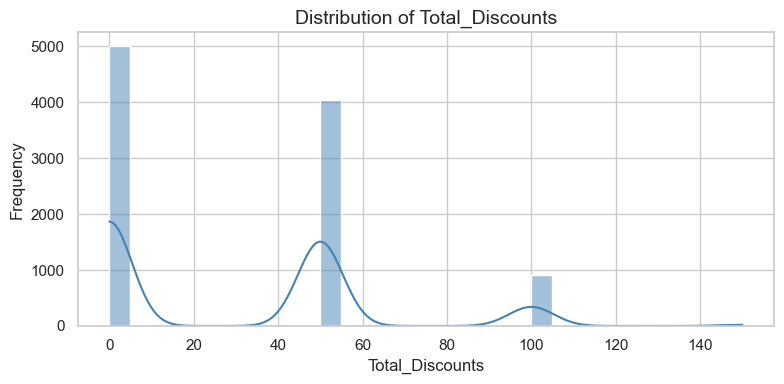

In [8]:
sns.set(style="whitegrid")

# List of important numeric features for distribution analysis
selected_numeric = ['Age', 'Premium_Amount', 'Claims_Frequency', 'Credit_Score', 'Website_Visits', 'Total_Discounts']

# Plot distributions
for col in selected_numeric:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True, color='steelblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

> 1. **Age Distribution**   
The histogram likely shows a bell-shaped curve with some skewness, centered around middle-aged adults (30–55). There may be smaller tails of younger and older individuals.

> 2. **Premium_Amount Distribution**
Highly right-skewed distribution, most customers pay a moderate premium (e.g., $200–$600), but a small group pays very high premiums ($1000+)

> 3. **Claims_Frequency**
A discrete distribution, likely with spikes at 0, 1, and 2 claims. Most customers make no claims during the policy period.

> 4. **Credit_Score Distribution**
A relatively normal distribution, probably centered around scores of 650–750, which is typical in consumer credit data.

> 5. **Website_Visits**
A positively skewed discrete variable, most customers visit 2–4 times before converting, with some reaching 10+ visits

> 6. **Total_Discounts**
Often bimodal or tiered, one group gets 0 or low discounts; another receives high bundling/multi-policy discounts.

# Conversion Rate by Region and Policy Type & Conversion Status

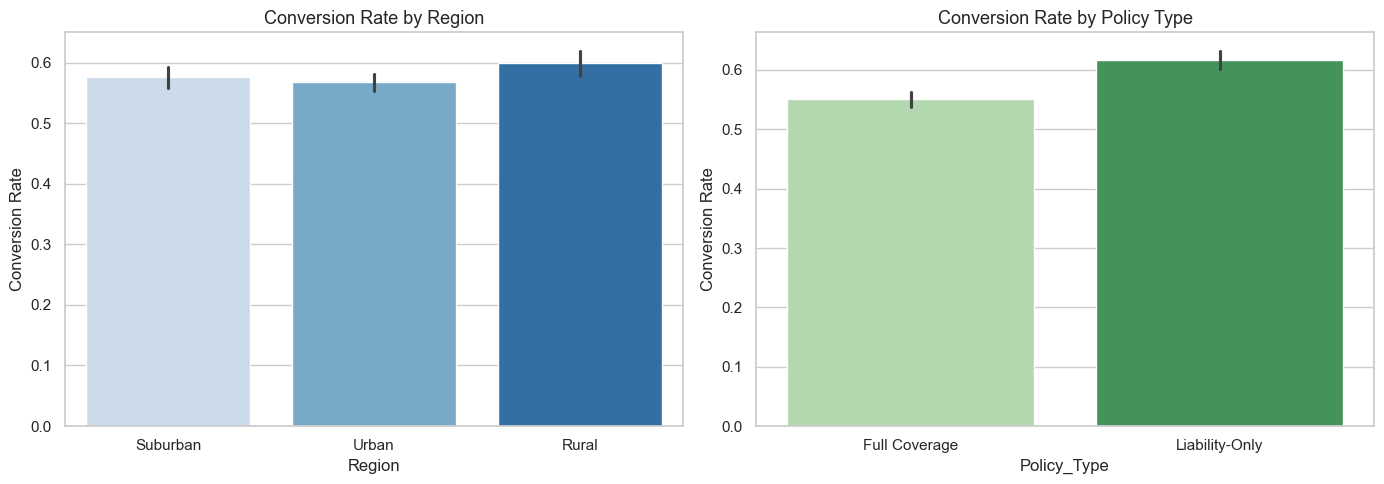

<Axes: xlabel='Conversion_Status', ylabel='Credit_Score'>

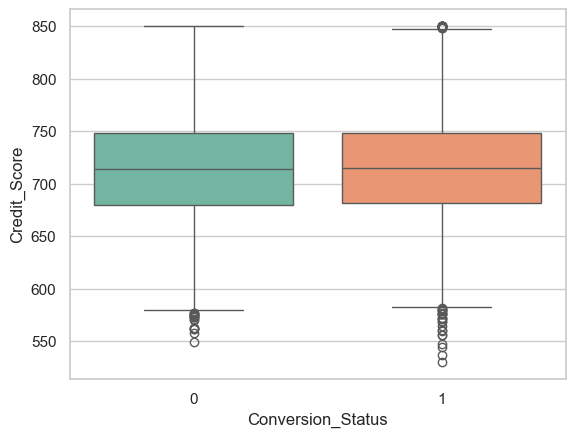

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Conversion Rate by Region
sns.barplot(data=df, x='Region', y='Conversion_Status', estimator=np.mean, ax=axes[0], palette='Blues')
axes[0].set_title("Conversion Rate by Region", fontsize=13)
axes[0].set_ylabel("Conversion Rate")

# Conversion Rate by Policy Type
sns.barplot(data=df, x='Policy_Type', y='Conversion_Status', estimator=np.mean, ax=axes[1], palette='Greens')
axes[1].set_title("Conversion Rate by Policy Type", fontsize=13)
axes[1].set_ylabel("Conversion Rate")

plt.tight_layout()
plt.show()
sns.boxplot(x='Conversion_Status', y='Credit_Score', data=df, hue='Conversion_Status', palette='Set2', legend=False)

**Conversion Rate by Region**
When examining average conversion rates by region, rural customers show the highest conversion rate, slightly above 60%.
This may be due to simpler insurance needs or fewer options, leading to quicker decision-making.
Urban and suburban customers display slightly lower conversion rates, around 56–57%, potentially reflecting longer research cycles or more competitive offerings in these areas.

**Conversion Rate by Policy Type**
Customers opting for Liability-Only policies have a notably higher conversion rate than those selecting Full Coverage.
This trend suggests that cost-conscious users—likely more price-sensitive or seeking basic coverage are more likely to convert quickly.
In contrast, Full Coverage customers may take more time to compare plans, leading to slightly lower conversion rates.

**Credit Score by Conversion Status**
Credit scores among customers who converted were slightly higher on average compared to those who didn’t.
While the difference in medians is visible, the overall distributions show significant overlap, indicating that credit score is a contributing factor but not a sole predictor of conversion.
This insight supports the idea of using credit score as one of several inputs for segmentation, rather than relying on it in isolation.

# Boxplots for Feature Comparison by Region

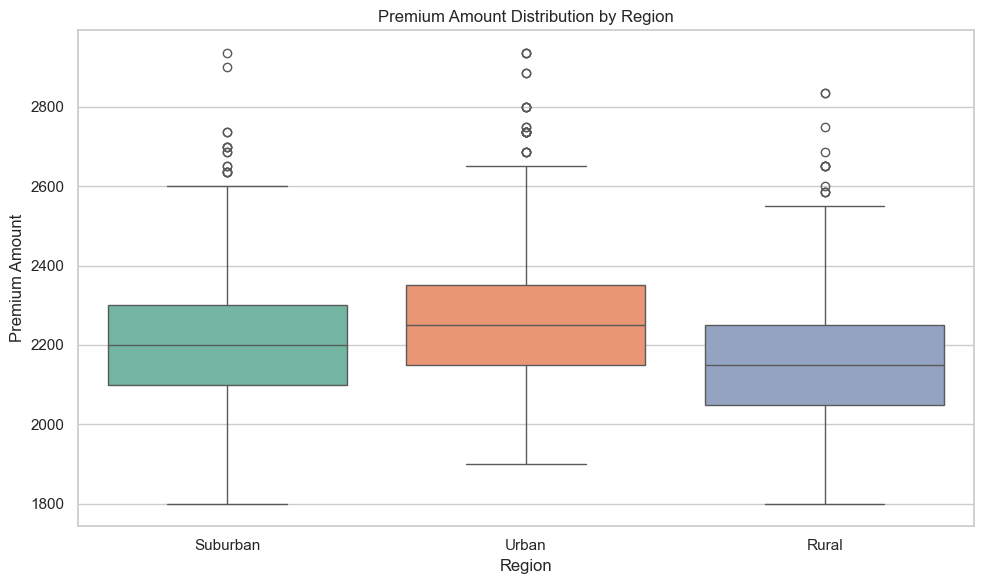

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Region', y='Premium_Amount', palette='Set2')
plt.title("Premium Amount Distribution by Region")
plt.xlabel("Region")
plt.ylabel("Premium Amount")
plt.tight_layout()
plt.show()

The boxplot analysis reveals distinct premium distribution patterns across regions.
Urban customers have the highest median premium and a wider interquartile range (IQR), suggesting greater variability in premium amounts—likely influenced by higher risk profiles or more coverage options.
Rural customers consistently pay the lowest premiums with a tighter IQR and fewer outliers, indicating more uniform pricing.
Suburban regions fall between the two, showing a balanced spread of premium values.
This regional disparity highlights the importance of geography in insurance pricing strategies.

## Data Preprocessing

## One-Hot Encoding of Categorical Variables

In [20]:
# Handle missing values with median (numeric only)
df.fillna(df.median(numeric_only=True), inplace=True)

# One-hot encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns

# Detecting more categorical columns
for i in df.drop(categorical_cols, axis=1).columns.values:
    if df[i].nunique()<11:
        categorical_cols=np.append(categorical_cols, i)

print("Categorical Columns:", categorical_cols)

# One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Transformed DataFrame:\n", df.head())

Categorical Columns: ['Marital_Status' 'Prior_Insurance' 'Claims_Severity' 'Policy_Type'
 'Source_of_Lead' 'Region' 'Is_Senior' 'Married_Premium_Discount'
 'Prior_Insurance_Premium_Adjustment' 'Claims_Frequency'
 'Claims_Adjustment' 'Policy_Adjustment' 'Safe_Driver_Discount'
 'Multi_Policy_Discount' 'Bundling_Discount' 'Total_Discounts'
 'Conversion_Status' 'Inquiries' 'Quotes_Requested'
 'Premium_Adjustment_Credit' 'Premium_Adjustment_Region']
Transformed DataFrame:
    Age  Premium_Amount  Time_Since_First_Contact  Website_Visits  \
0   47            2286                        10               5   
1   37            2336                        22               5   
2   49            2386                        28               4   
3   62            2336                         4               6   
4   36            2350                        14               8   

   Time_to_Conversion  Credit_Score  Marital_Status_Married  \
0                  99           704                    

**This process ensures the dataset is clean, numerically consistent, and machine learning ready — no missing values and all features are in a format that models can process.We have also created dummy variables through one-hot encoding**

### Outliers using IQR

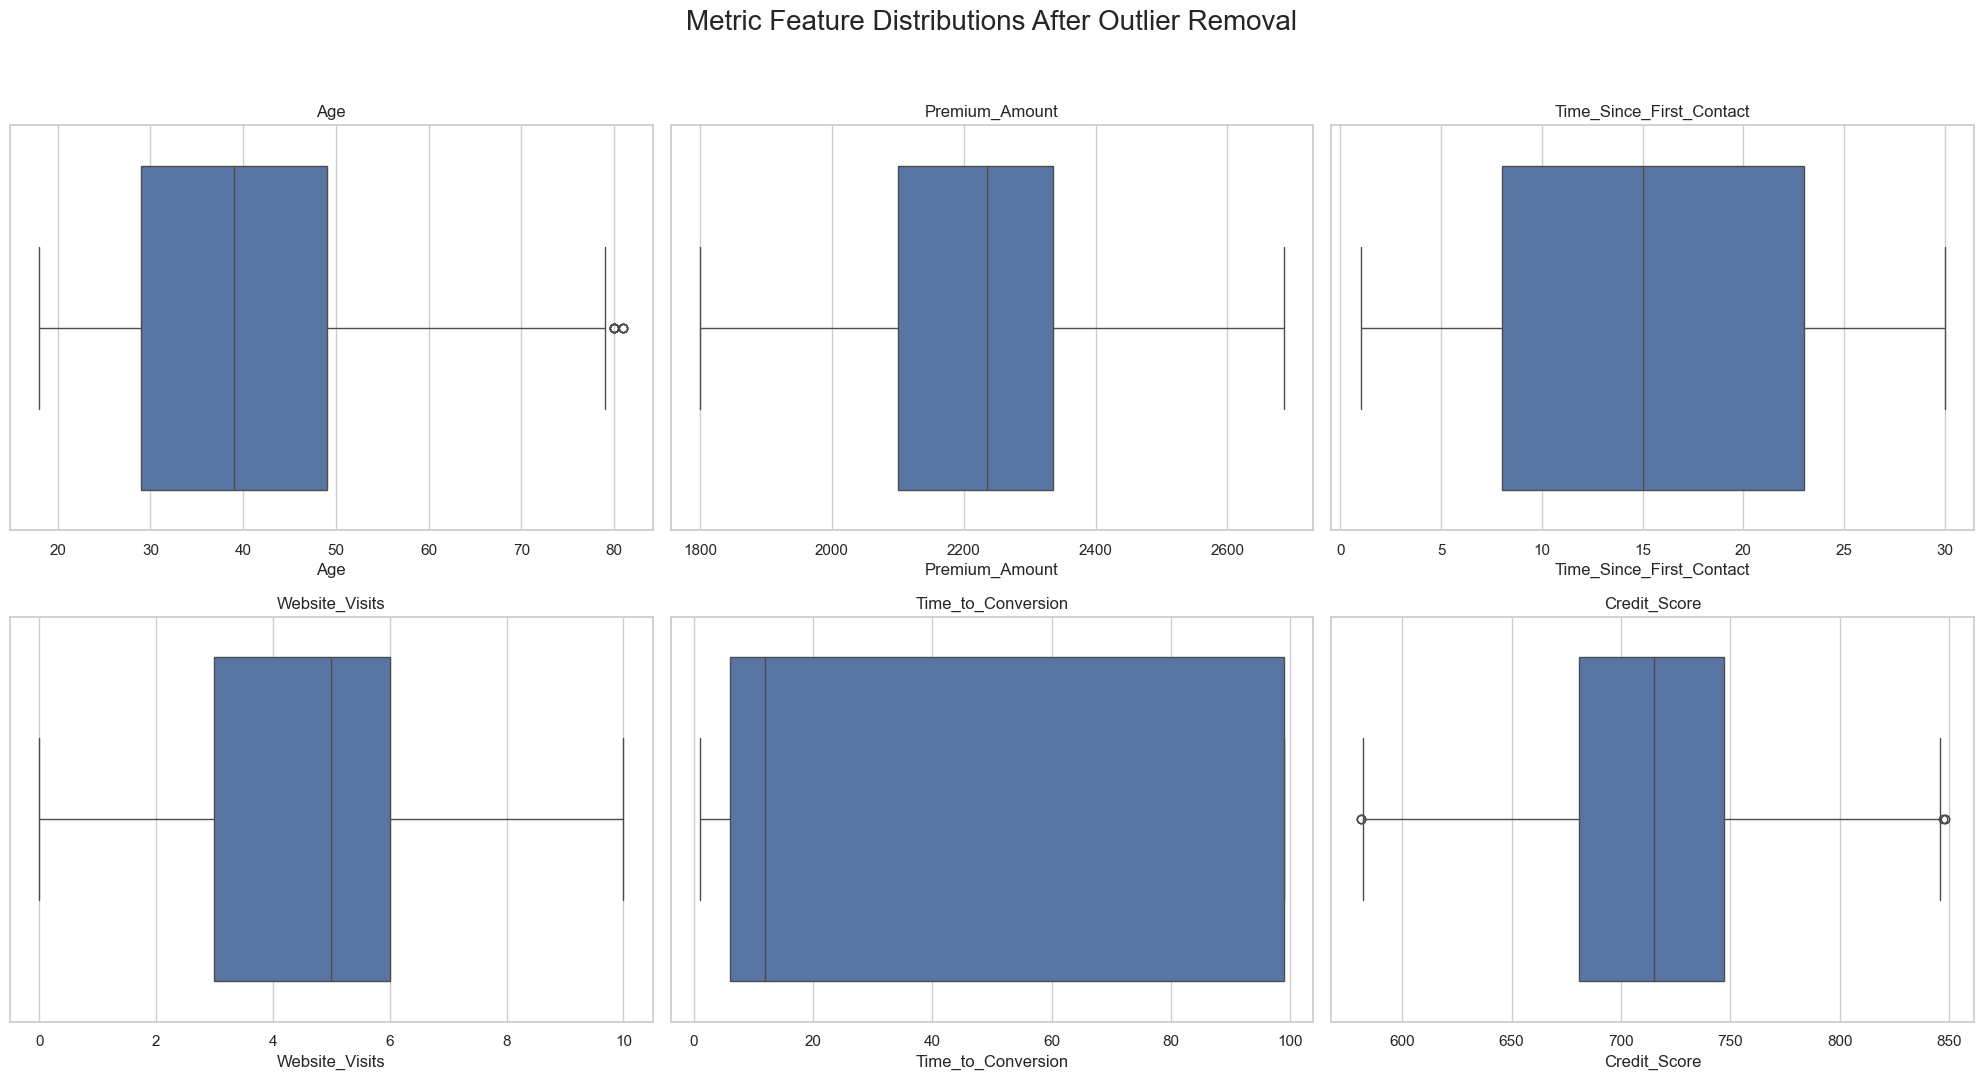

In [21]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# 3. Compute IQR and remove outliers
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers row-wise
df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# 4. Plot boxplots of numerical columns *after* outlier removal
fig, axes = plt.subplots(2, ceil(len(numeric_cols) / 2), figsize=(20, 11))
fig.subplots_adjust(hspace=0.5)

# Explain code
for ax, feat in zip(axes.flatten(), numeric_cols):
    sns.boxplot(x=df[feat], ax=ax)
    ax.set_title(f"{feat}")

plt.suptitle("Metric Feature Distributions After Outlier Removal", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

1. **Age**

The data is now well-centered around ages 30–50 with very few high-end outliers.
Most customers fall within a typical working-age range, indicating good clustering potential.

2. **Premium_Amount**

The range is now tightened between approx. 2000–2500, removing earlier extreme premium values.
This ensures high-paying outliers won’t distort distance-based clustering like KMeans.

3. **Time_Since_First_Contact**

Uniformly spread, with no extreme outliers. Suggests balanced engagement timing across customers.

4. **Website_Visits**

Well-balanced with a median around 5 visits. No visible outliers — most users visit between 3 to 7 times before converting or dropping off.
Indicates consistent user engagement and a great feature for clustering on lead interest.

5. **Time_to_Conversion**

Very wide spread, from 0 up to nearly 100 days. Median is around 10–15 days, but upper range is long.
This variation is important for identifying fast vs. slow converters — potential for a behavioral segment.

6. **Credit_Score**

Tight IQR centered around 700–750, which is expected for average customers.Some outliers exist on both ends (below 600 and above 800), but well-distributed.Still a solid feature for financial segmentation.

### Feature Scaling

Standardizing is critical before applying distance-based algorithms like KMeans, DBSCAN, GMM, or PCA, so that features with larger ranges (e.g., Premium_Amount) don’t dominate others (e.g., Website_Visits).

In [25]:
# Scale Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled

,Age,Premium_Amount,Time_Since_First_Contact,Website_Visits,Time_to_Conversion,Credit_Score,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widowed,Prior_Insurance_<1 year,...,Inquiries_5,Inquiries_6,Inquiries_7,Inquiries_8,Inquiries_9,Quotes_Requested_2,Quotes_Requested_3,Premium_Adjustment_Credit_50,Premium_Adjustment_Region_50,Premium_Adjustment_Region_100
0,0.513316,0.469756,-0.630661,0.032597,1.163104,-0.212885,1.021195,-0.697859,-0.317335,-0.520547,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,1.418038,-0.705526,-0.791851,1.520229,-0.983888
1,-0.208095,0.813671,0.752851,0.032597,1.163104,0.242932,1.021195,-0.697859,-0.317335,-0.520547,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,1.418038,-0.705526,-0.791851,-0.657796,1.016376
2,0.657598,1.157586,1.444607,-0.441397,1.163104,1.196003,1.021195,-0.697859,-0.317335,-0.520547,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,-0.705200,-0.705526,-0.791851,-0.657796,1.016376
3,1.595433,0.813671,-1.322416,0.506591,-0.971362,1.962604,1.021195,-0.697859,-0.317335,-0.520547,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,1.418038,-0.705526,-0.791851,-0.657796,1.016376
4,-0.280237,0.909967,-0.169490,1.454579,-0.795324,-1.083080,-0.979245,1.432954,-0.317335,-0.520547,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,1.418038,-0.705526,1.262864,1.520229,-0.983888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,1.379010,0.222137,-1.091831,-0.441397,-0.817329,1.423912,-0.979245,1.432954,-0.317335,-0.520547,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,1.418038,-0.705526,-0.791851,-0.657796,1.016376
9724,-1.578777,1.501502,-1.437709,0.506591,-0.883343,-0.979485,1.021195,-0.697859,-0.317335,-0.520547,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,-0.705200,1.417381,1.262864,-0.657796,1.016376
9725,-0.785225,1.845417,1.559899,-0.915391,-0.949358,-1.601053,1.021195,-0.697859,-0.317335,1.921055,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,-0.705200,1.417381,1.262864,-0.657796,1.016376
9726,0.513316,-0.465694,-0.861246,-1.389385,-0.729310,-0.793015,-0.979245,1.432954,-0.317335,1.921055,...,-0.190306,-0.114091,-0.059223,-0.022677,-0.017564,-0.705200,-0.705526,1.262864,1.520229,-0.983888


In [24]:
# Confirm shape and usage
print("Scaled feature matrix shape:", df_scaled.shape)
n_features = df_scaled.shape[1]
min_samples = n_features + 1
print("Using min_samples =", min_samples)
df_scaled = pd.DataFrame(df_scaled, columns=df_scaled.columns)
print("Data successfully scaled and ready for clustering.")

Scaled feature matrix shape: (9728, 58)
Using min_samples = 59
Data successfully scaled and ready for clustering.


## Clustering Methods Explained

Before diving into clustering, it's crucial to understand why we use multiple methods:

- **KMeans**: Efficient and commonly used; works well when clusters are spherical and similarly sized.
- **DBSCAN**: Useful for discovering clusters of arbitrary shapes and detecting noise/outliers.
- **Gaussian Mixture Models (GMM)**: A probabilistic model that accommodates overlapping clusters.
- **Hierarchical Clustering**: Builds a tree of clusters, useful for understanding data structure without predefining cluster count.

## KMEANS Clustering

In [26]:
distortions = []
silhouette_scores = []
K_range = range(2, 10)

# Getting best K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

optimal_k= K_range[np.argmax(silhouette_scores)]

optimal_k

2

>We applied KMeans clustering across a range of cluster values (K = 2 to 9) and calculated the Silhouette Score for each. 
Silhouette Score measures how well-separated and cohesive the clusters are.

>By maximizing the Silhouette Score, we automatically identified the optimal number of clusters.
This ensures the resulting segments are internally consistent and clearly differentiated, which is crucial for meaningful customer segmentation.

In [46]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

## GMM Clustering 

In [28]:
k_range = range(1, 10)
silhouette_scores=[]

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_scaled)
    labels=gmm.fit_predict(df_scaled)
    if len(np.unique(labels)) > 1:
        score = silhouette_score(df_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)

optimal_k = k_range[np.argmax(silhouette_scores)]

optimal_k

2

> In this step, we applied GMM clustering with different numbers of components (K = 1 to 9) and evaluated each using the Silhouette Score.

> By identifying the value of K that maximizes the Silhouette Score, we selected the optimal number of GMM clusters.
This helps ensure the clusters are well-separated, even when they overlap, which GMM handles better than KMeans.

> GMM allows for softer, probabilistic clustering, and this method ensures we pick the most stable and meaningful number of segments

In [29]:
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(df_scaled)

## Hierarchical Clustering

In [30]:
from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(df_scaled, method='ward')

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    labels = fcluster(Z, k, criterion='maxclust')
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)

optimal_k = k_range[np.argmax(silhouette_scores)]

optimal_k

2

> In this step, we applied Hierarchical Clustering using the Ward linkage method, which minimizes variance within clusters.

> We then tested different numbers of clusters (K = 2 to 10) using fcluster() and calculated the Silhouette Score for each.

> By selecting the K with the highest Silhouette Score, we identified the optimal number of hierarchical clusters, ensuring well-separated and compact groupings.

> This approach provides an interpretable cluster structure (dendrogram) and selects the most stable configuration for segmentation.

In [31]:
df['HierCluster'] = fcluster(Z, optimal_k, criterion='maxclust')

## DBSCAN Clustering

In [32]:
pca = PCA().fit(df_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1

# Reduce data to components that explain 80% of the variance
pca = PCA(n_components=n_components_80)
X_reduced = pca.fit_transform(df_scaled)

# Use K Nearest Neighbors to calculate dinstances between data points
neighbors = NearestNeighbors(n_neighbors=n_components_80)
neighbors_fit = neighbors.fit(X_reduced)
distances, indices = neighbors_fit.kneighbors(X_reduced)

# Use those distances to calculate with the help of knee where the data has a separation between data points
k_distances = np.sort(distances[:, n_components_80-1])
knee = KneeLocator(range(len(k_distances)), k_distances, curve='convex', direction='increasing')
best_eps = k_distances[knee.knee] if knee.knee is not None else 0.5

best_eps

9.058616428492881

> DBSCAN Optimal eps Selection 
We used PCA to reduce dimensions while preserving 80% of the variance, then applied K-Nearest Neighbors to calculate point-to-point distances.

> Using the KneeLocator, we identified the point where distances show the sharpest increase — this gives the optimal eps value for DBSCAN.

> This method ensures DBSCAN finds well-separated, meaningful clusters while filtering out noise effectively.

In [33]:
# Fit DBSCAN
dbscan = DBSCAN(eps=best_eps, min_samples=n_components_80)  # You can fine-tune eps and min_samples
df['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)

## Compare Silhouette Scores

In [34]:
def safe_silhouette(data, labels, name):
    if len(set(labels)) > 1 and len(set(labels)) < len(labels):
        score = silhouette_score(data, labels)
        print(f"Silhouette Score - {name}: {score:.3f}")
        return score
    else:
        print(f"Silhouette Score - {name}: Not applicable (only one cluster or too noisy)")
        return None

In [35]:
score_kmeans = safe_silhouette(df_scaled, df['KMeans_Cluster'], 'KMeans')
score_gmm = safe_silhouette(df_scaled, df['GMM_Cluster'], 'GMM')
score_hier = safe_silhouette(df_scaled, df['HierCluster'], 'Hierarchical')
score_dbscan = safe_silhouette(df_scaled, df['DBSCAN_Cluster'], 'DBSCAN')

Silhouette Score - KMeans: 0.443
Silhouette Score - GMM: 0.443
Silhouette Score - Hierarchical: 0.517
Silhouette Score - DBSCAN: 0.425


## Clustering Model Performance Summary
- Hierarchical Clustering performed best (Silhouette = 0.517) — shows clear, well-separated clusters.

- KMeans and GMM performed moderately well (0.443) — suitable for general clustering with solid separation.

- DBSCAN scored lowest (0.425) — may need further tuning, better for noise detection or irregular clusters.

## Visual Comparison of Clusters Using PCA

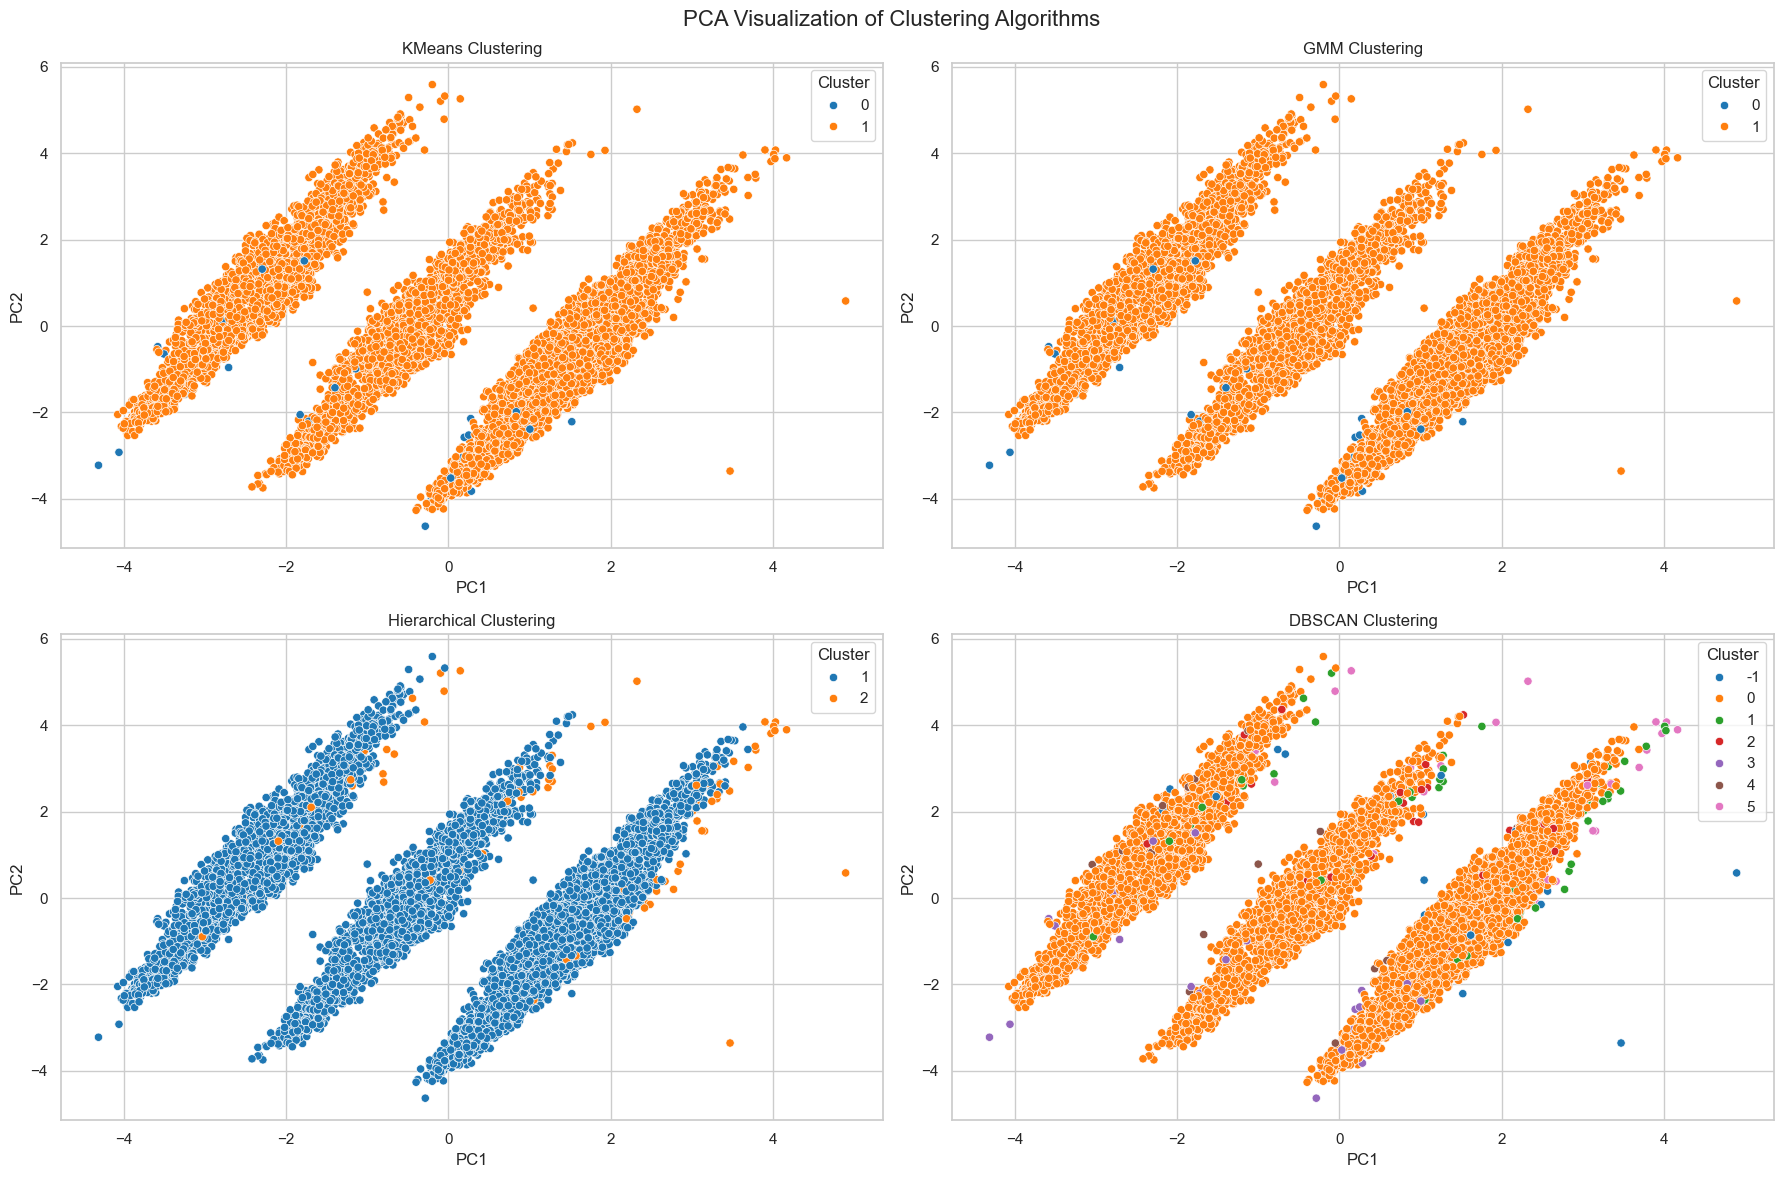

In [36]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# KMeans
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['KMeans_Cluster'],
                palette='tab10', ax=axs[0, 0])
axs[0, 0].set_title("KMeans Clustering")

# GMM
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['GMM_Cluster'],
                palette='tab10', ax=axs[0, 1])
axs[0, 1].set_title("GMM Clustering")

# Hierarchical
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['HierCluster'],
                palette='tab10', ax=axs[1, 0])
axs[1, 0].set_title("Hierarchical Clustering")

# DBSCAN
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['DBSCAN_Cluster'],
                palette='tab10', ax=axs[1, 1])
axs[1, 1].set_title("DBSCAN Clustering")

for ax in axs.flat:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(title="Cluster")

plt.suptitle("PCA Visualization of Clustering Algorithms", fontsize=16)
plt.tight_layout()
plt.show()

### View Cluster Counts

In [37]:
print("Cluster Counts:")
print(df[['KMeans_Cluster', 'GMM_Cluster', 'HierCluster', 'DBSCAN_Cluster']].nunique())

Cluster Counts:
KMeans_Cluster    2
GMM_Cluster       2
HierCluster       2
DBSCAN_Cluster    7
dtype: int64


## Human Approach Clustering

In [38]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

In [39]:
df['HierCluster'] = fcluster(Z, 4, criterion='maxclust')

In [40]:
dbscan = DBSCAN(eps=5.0, min_samples=59)  # You can fine-tune eps and min_samples
df['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)

In [41]:
gmm = GaussianMixture(n_components=4, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(df_scaled)

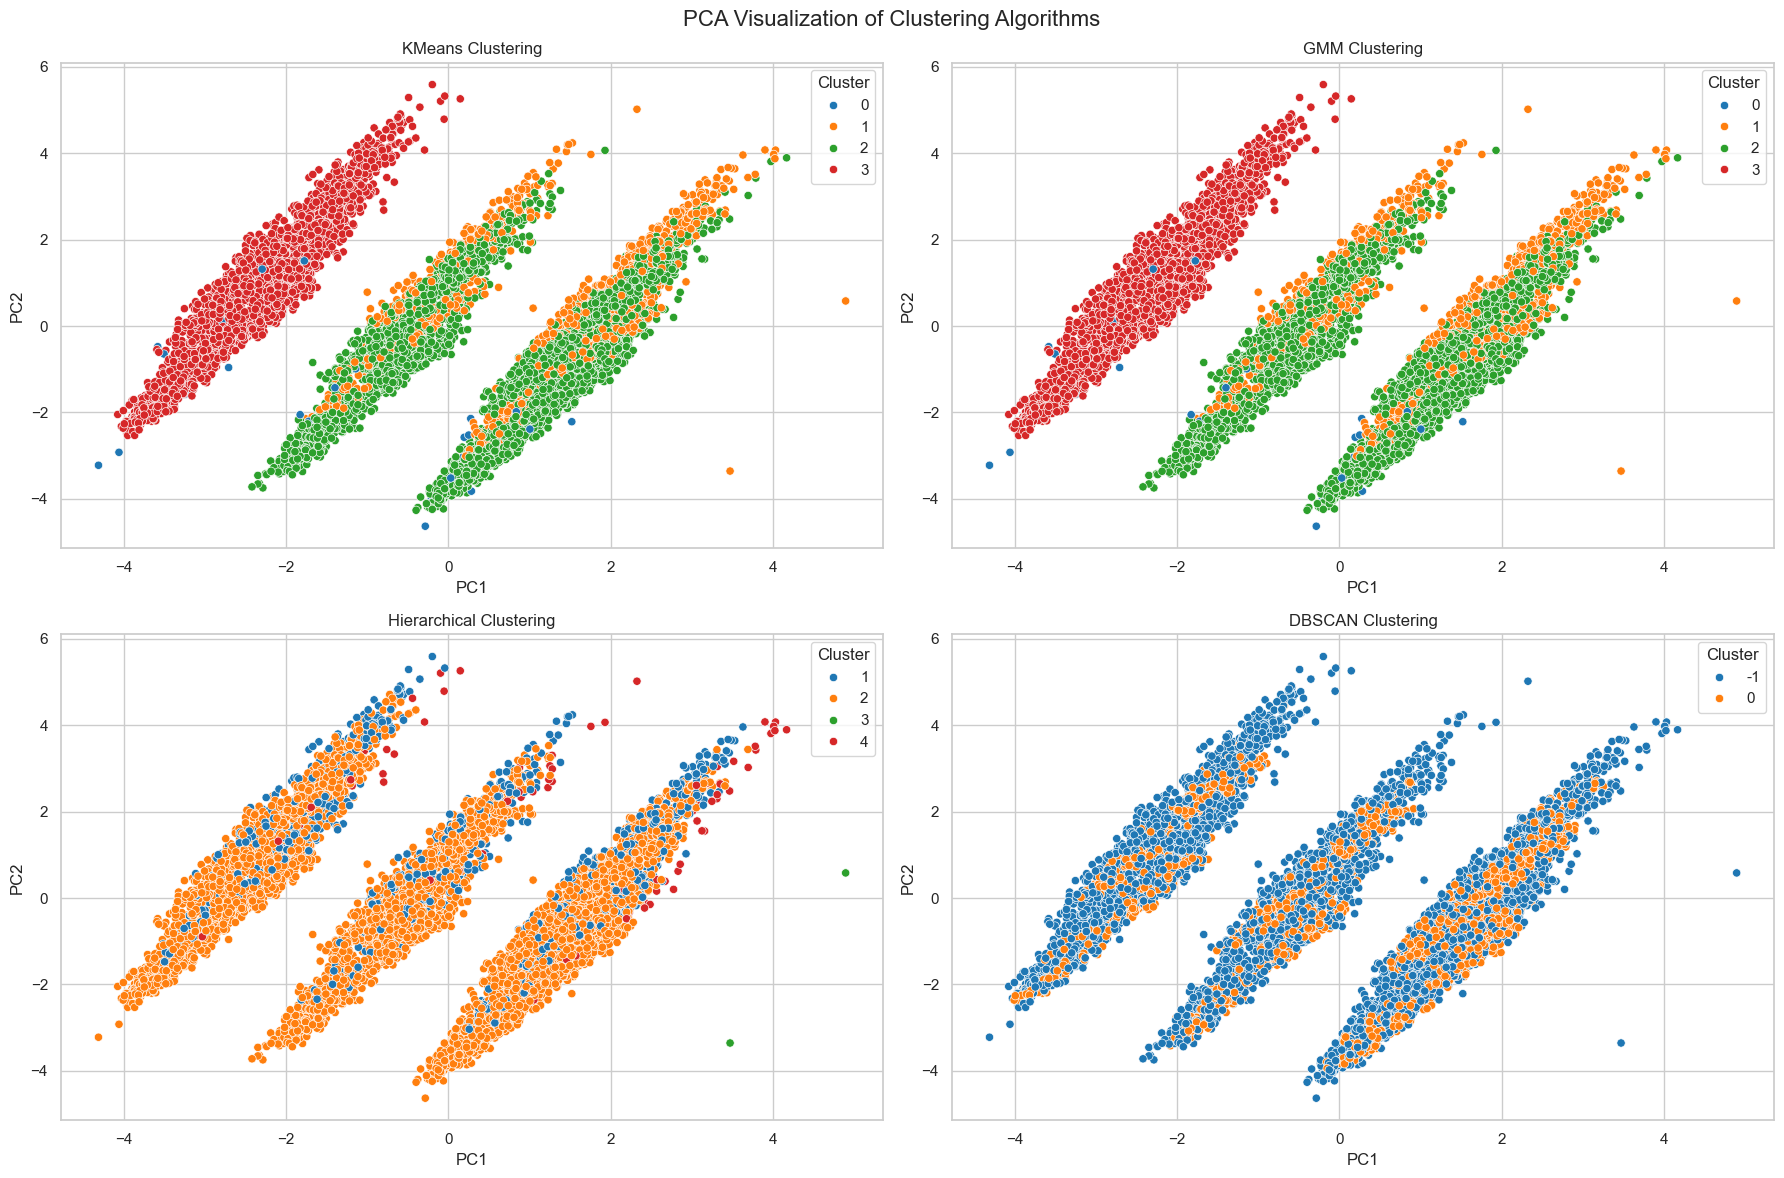

In [42]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# KMeans
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['KMeans_Cluster'],
                palette='tab10', ax=axs[0, 0])
axs[0, 0].set_title("KMeans Clustering")

# GMM
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['GMM_Cluster'],
                palette='tab10', ax=axs[0, 1])
axs[0, 1].set_title("GMM Clustering")

# Hierarchical
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['HierCluster'],
                palette='tab10', ax=axs[1, 0])
axs[1, 0].set_title("Hierarchical Clustering")

# DBSCAN
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['DBSCAN_Cluster'],
                palette='tab10', ax=axs[1, 1])
axs[1, 1].set_title("DBSCAN Clustering")

for ax in axs.flat:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(title="Cluster")

plt.suptitle("PCA Visualization of Clustering Algorithms", fontsize=16)
plt.tight_layout()
plt.show()

In [43]:
score_kmeans = safe_silhouette(df_scaled, df['KMeans_Cluster'], 'KMeans')
score_gmm = safe_silhouette(df_scaled, df['GMM_Cluster'], 'GMM')
score_hier = safe_silhouette(df_scaled, df['HierCluster'], 'Hierarchical')
score_dbscan = safe_silhouette(df_scaled, df['DBSCAN_Cluster'], 'DBSCAN')

Silhouette Score - KMeans: 0.068
Silhouette Score - GMM: 0.068
Silhouette Score - Hierarchical: 0.111
Silhouette Score - DBSCAN: -0.001


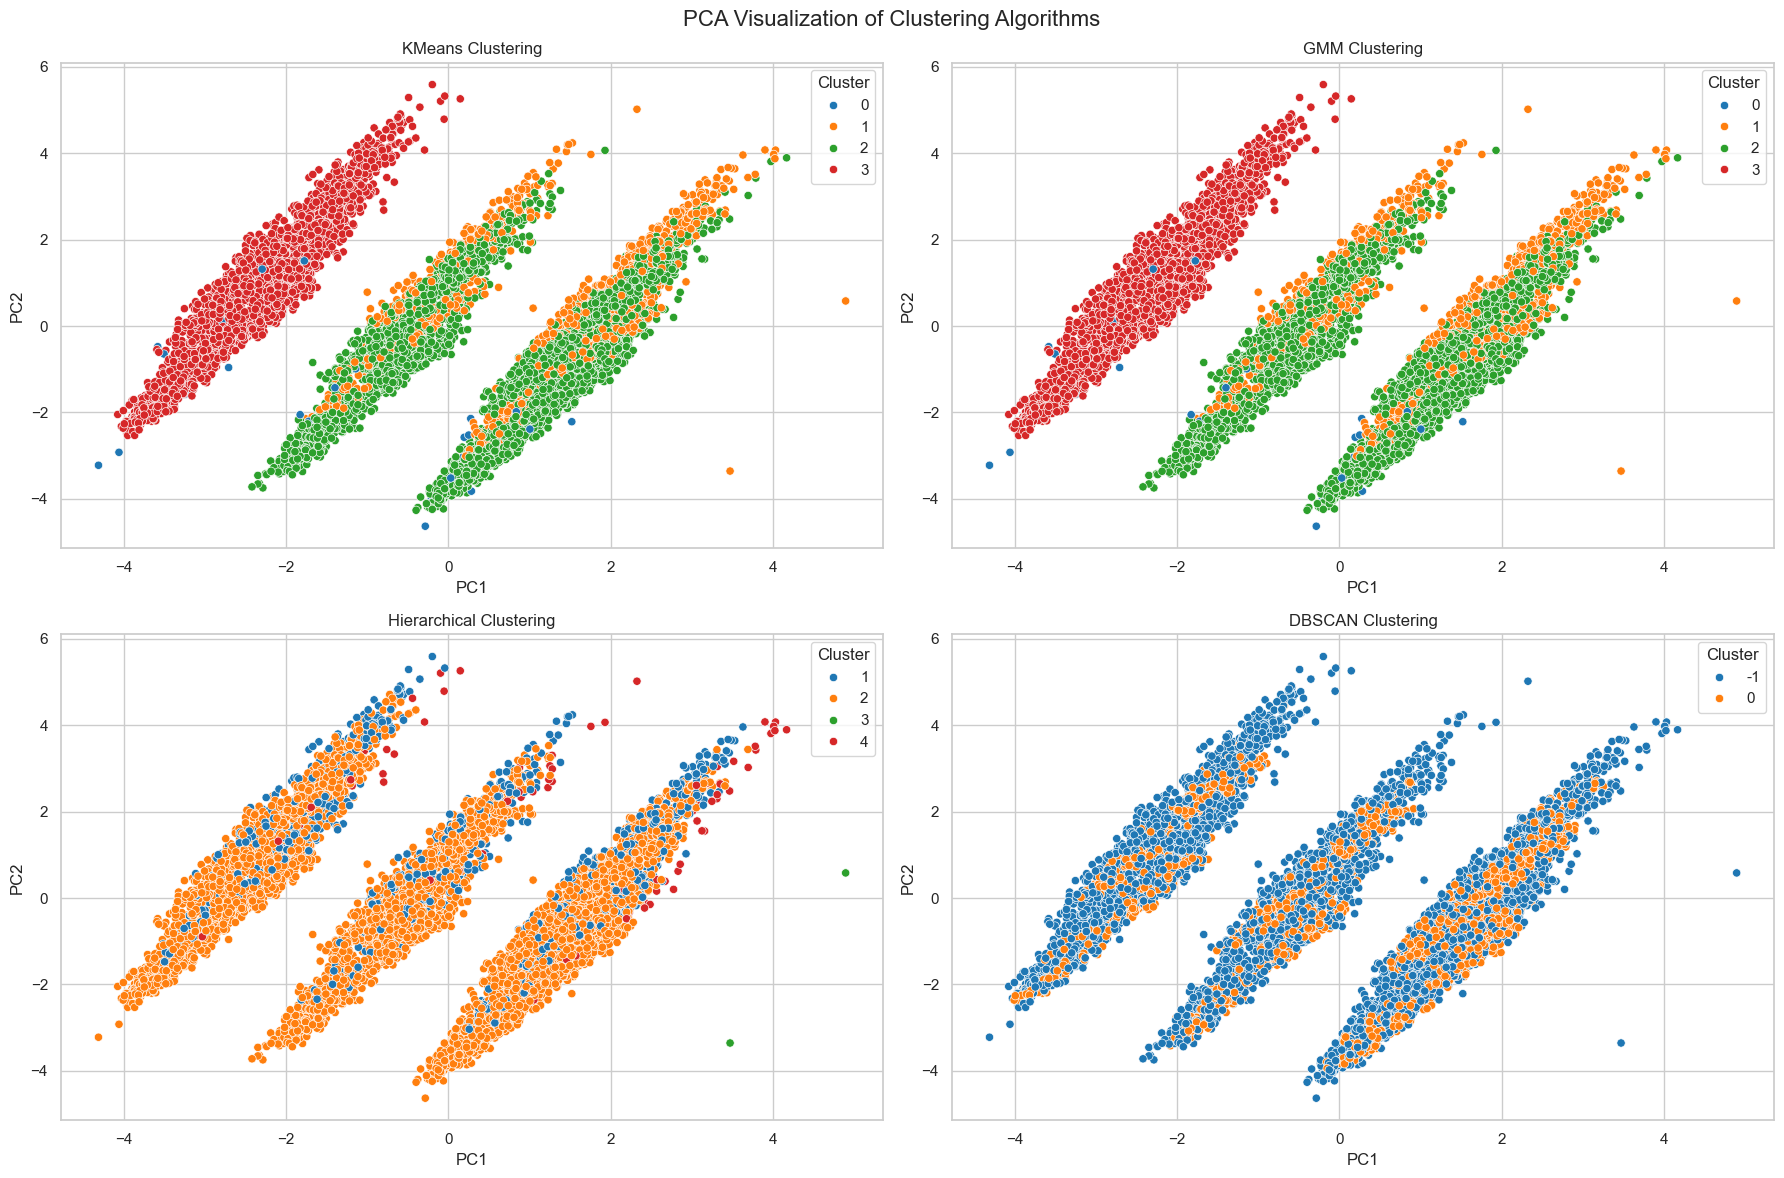

In [44]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# KMeans
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['KMeans_Cluster'],
                palette='tab10', ax=axs[0, 0])
axs[0, 0].set_title("KMeans Clustering")

# GMM
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['GMM_Cluster'],
                palette='tab10', ax=axs[0, 1])
axs[0, 1].set_title("GMM Clustering")

# Hierarchical
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['HierCluster'],
                palette='tab10', ax=axs[1, 0])
axs[1, 0].set_title("Hierarchical Clustering")

# DBSCAN
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['DBSCAN_Cluster'],
                palette='tab10', ax=axs[1, 1])
axs[1, 1].set_title("DBSCAN Clustering")

for ax in axs.flat:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(title="Cluster")

plt.suptitle("PCA Visualization of Clustering Algorithms", fontsize=16)
plt.tight_layout()
plt.show()